In [1]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import functions.nominal_rigidity_network as nominal_rigidity_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 3: Multiple Major Occupations

We now allow for a more flexible occupation-sector structure, using occupation-by-sector employment data from the Occupational Employment and Wage Statistics (OEWS). In particular, we are able to calibrate $\varepsilon^f_N$ and $\mathcal{L}$ from the OES, and we impute the other variables from sector-level data. 

In [2]:
A_spec = 1
data_dir = '../data/clean/'
dfTau    = pd.read_csv(data_dir + 'tau_2021_occu.csv').sort_values(by=['variable'])
dfepsN   = pd.read_csv(data_dir + 'epsN_2021.csv', index_col=0).sort_index(axis=1)
dfcurlyL = pd.read_csv(data_dir + 'curlyL_2021.csv', index_col=0).sort_index()
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors  = dfA['short_names']
dfDemand = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated_occu.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'variable'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]
dfMatching_params = pd.read_csv(data_dir + 'matching_param_estimates_occu.csv')
shares = pd.read_csv(data_dir + 'energy_capital_shares.csv')
sector_names = list(dfA['short_names']) + ['Agg Y']
occupation_names = list(dfcurlyL.index)

In [3]:
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
rescaler = np.matrix(1 - shares['Capital share'] - shares['Energy share'])
J = Omega.shape[0]
Omega = np.multiply(Omega, (np.repeat(rescaler, J).reshape(J, J)))
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
curlyL = np.array(dfcurlyL)

O = dfcurlyL.shape[0]

epsN = np.array((np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64') * dfepsN.T).T)
epsN = np.multiply(epsN, rescaler.T)
# normalized epsN to back out sectoral tightness
epsN_norm = np.array(dfepsN)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))
epsK = np.matrix(shares[['Capital share', 'Energy share']])
K = epsK.shape[1]

# if you want to turn off network linkages, uncomment these two lines of code.
# Omega = np.zeros_like(Omega)
# Psi = np.eye(Omega.shape[0])
θ = dfLabor_market_yearly['Tightness']
ν = dfMatching_params['unemployment_elasticity']

tau = dfTau['Tau']
curlyT = np.diag(tau)
curlyQ = np.diag(-ν)
curlyF =  np.eye(O) + curlyQ

## Calibration figures: Response to Energy Shock

The section below plots the model response to energy shocks. 

In [4]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.1 
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
secT_vec = np.zeros((J,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [5]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [6]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [7]:
sectorY_vec.shape

(14, 2)

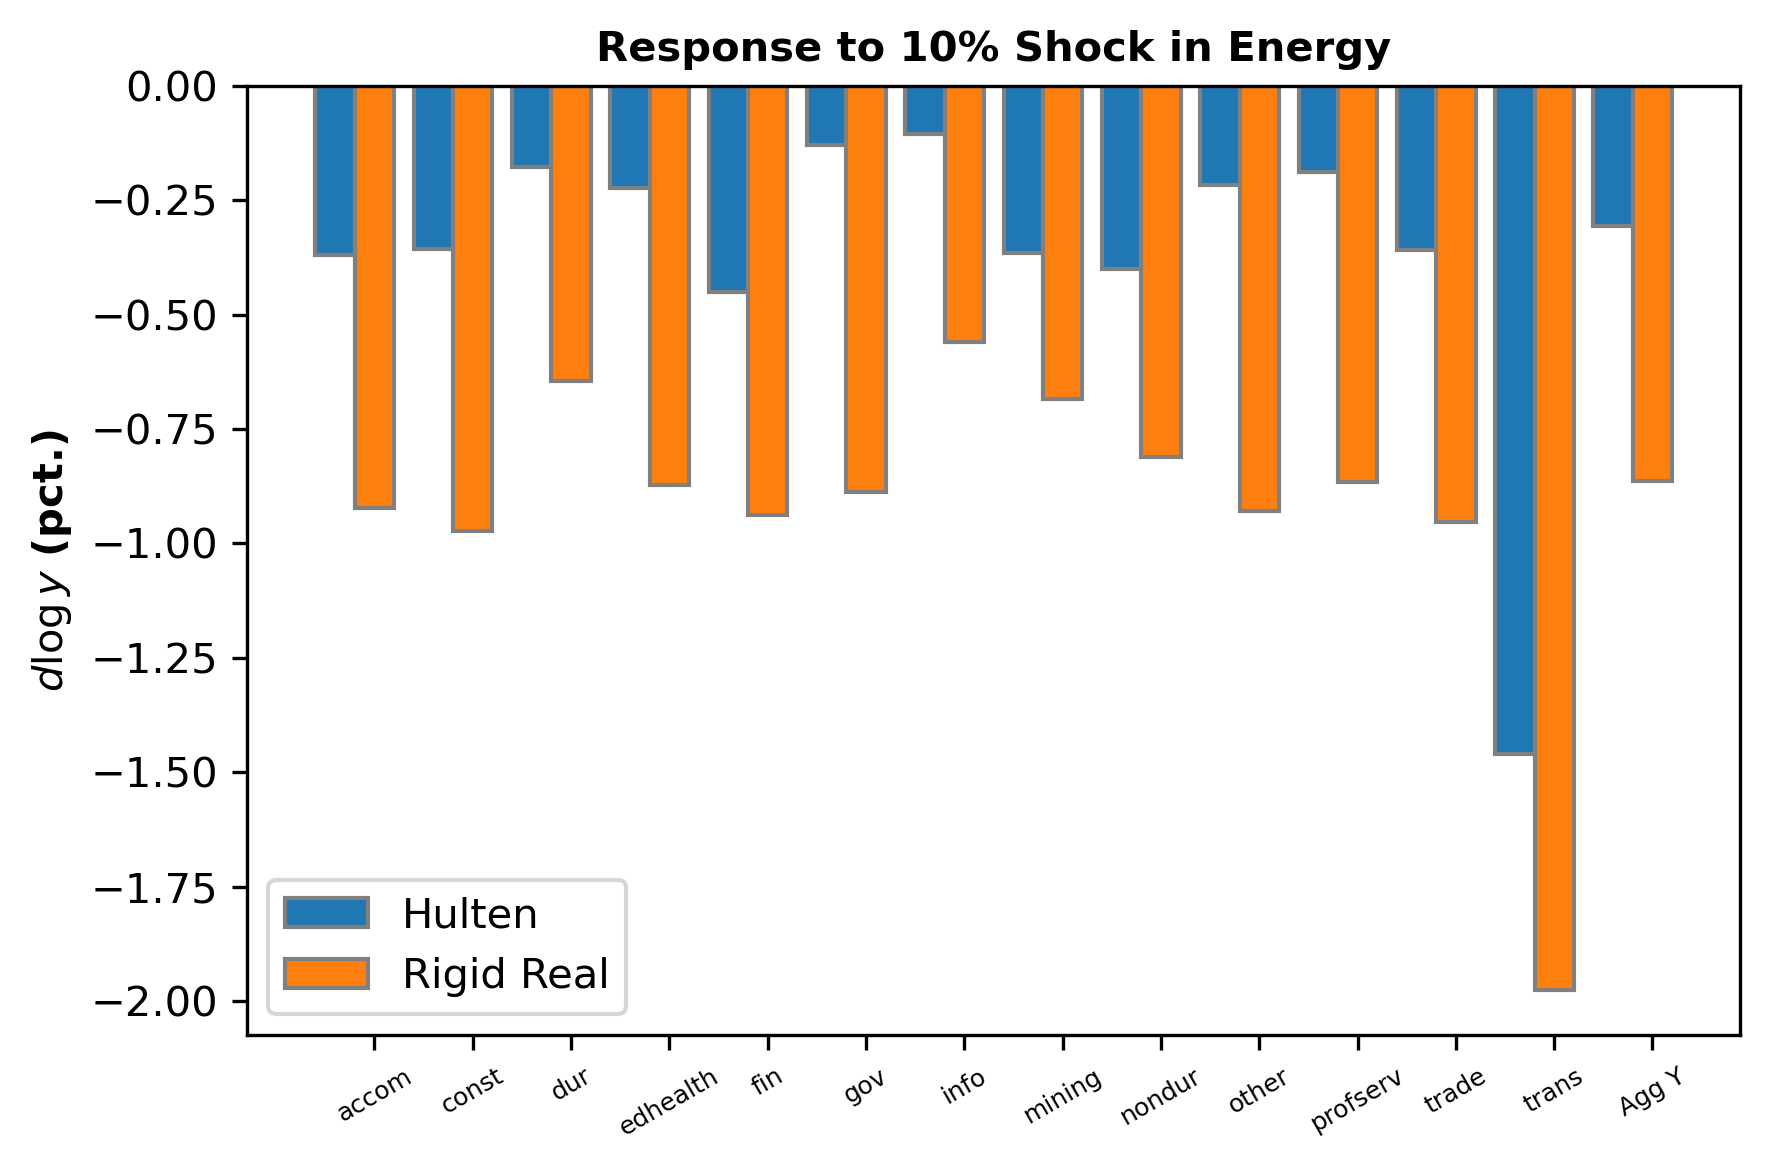

In [8]:
title = f'Response to 10% Shock in Energy'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_KshockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

In [9]:
occupation_names

['Admin',
 'Agg',
 'Arts',
 'Bus Ops',
 'Care',
 'Clean',
 'Cons',
 'Educ',
 'Eng',
 'Food S',
 'Health P',
 'Health S',
 'Legal',
 'Manag',
 'Math',
 'Prod',
 'Prot S',
 'Repair',
 'Sales',
 'Science',
 'Soc S',
 'Trans']

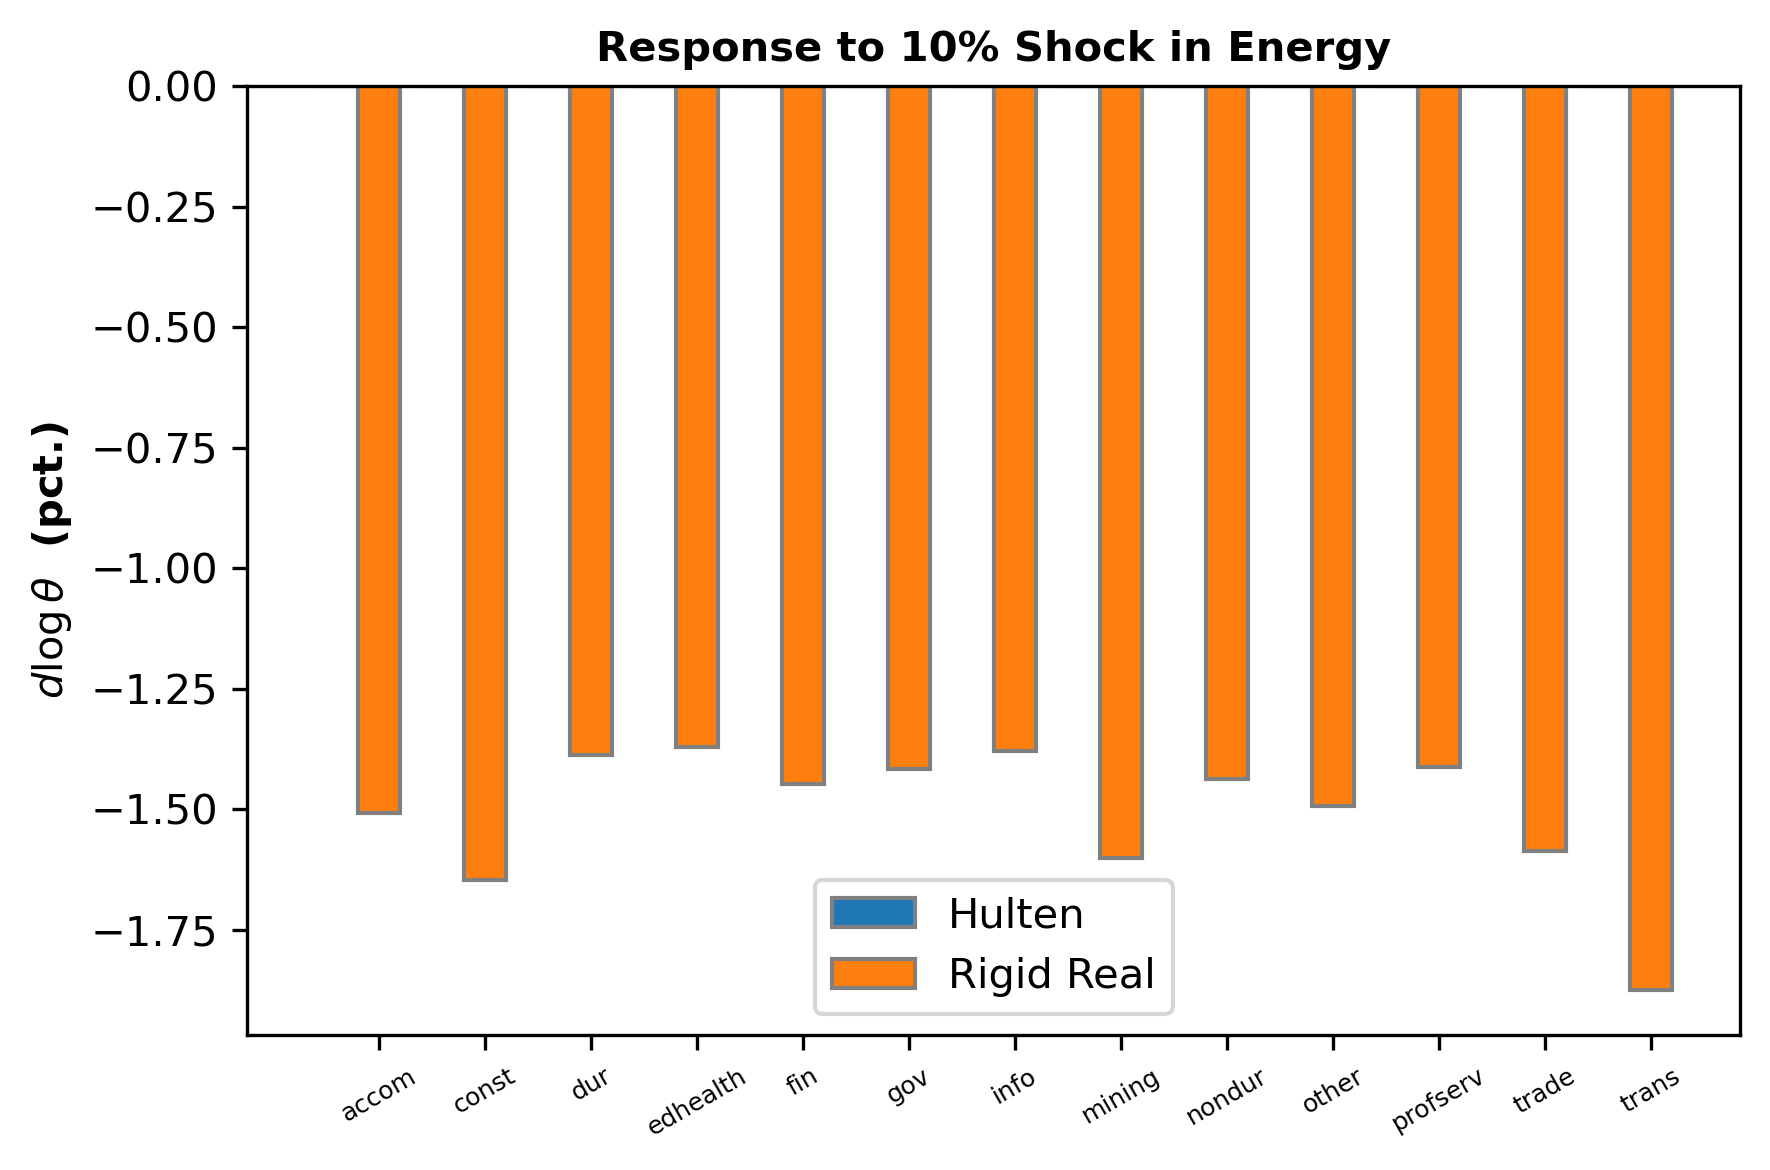

In [10]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_KshockTsec.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

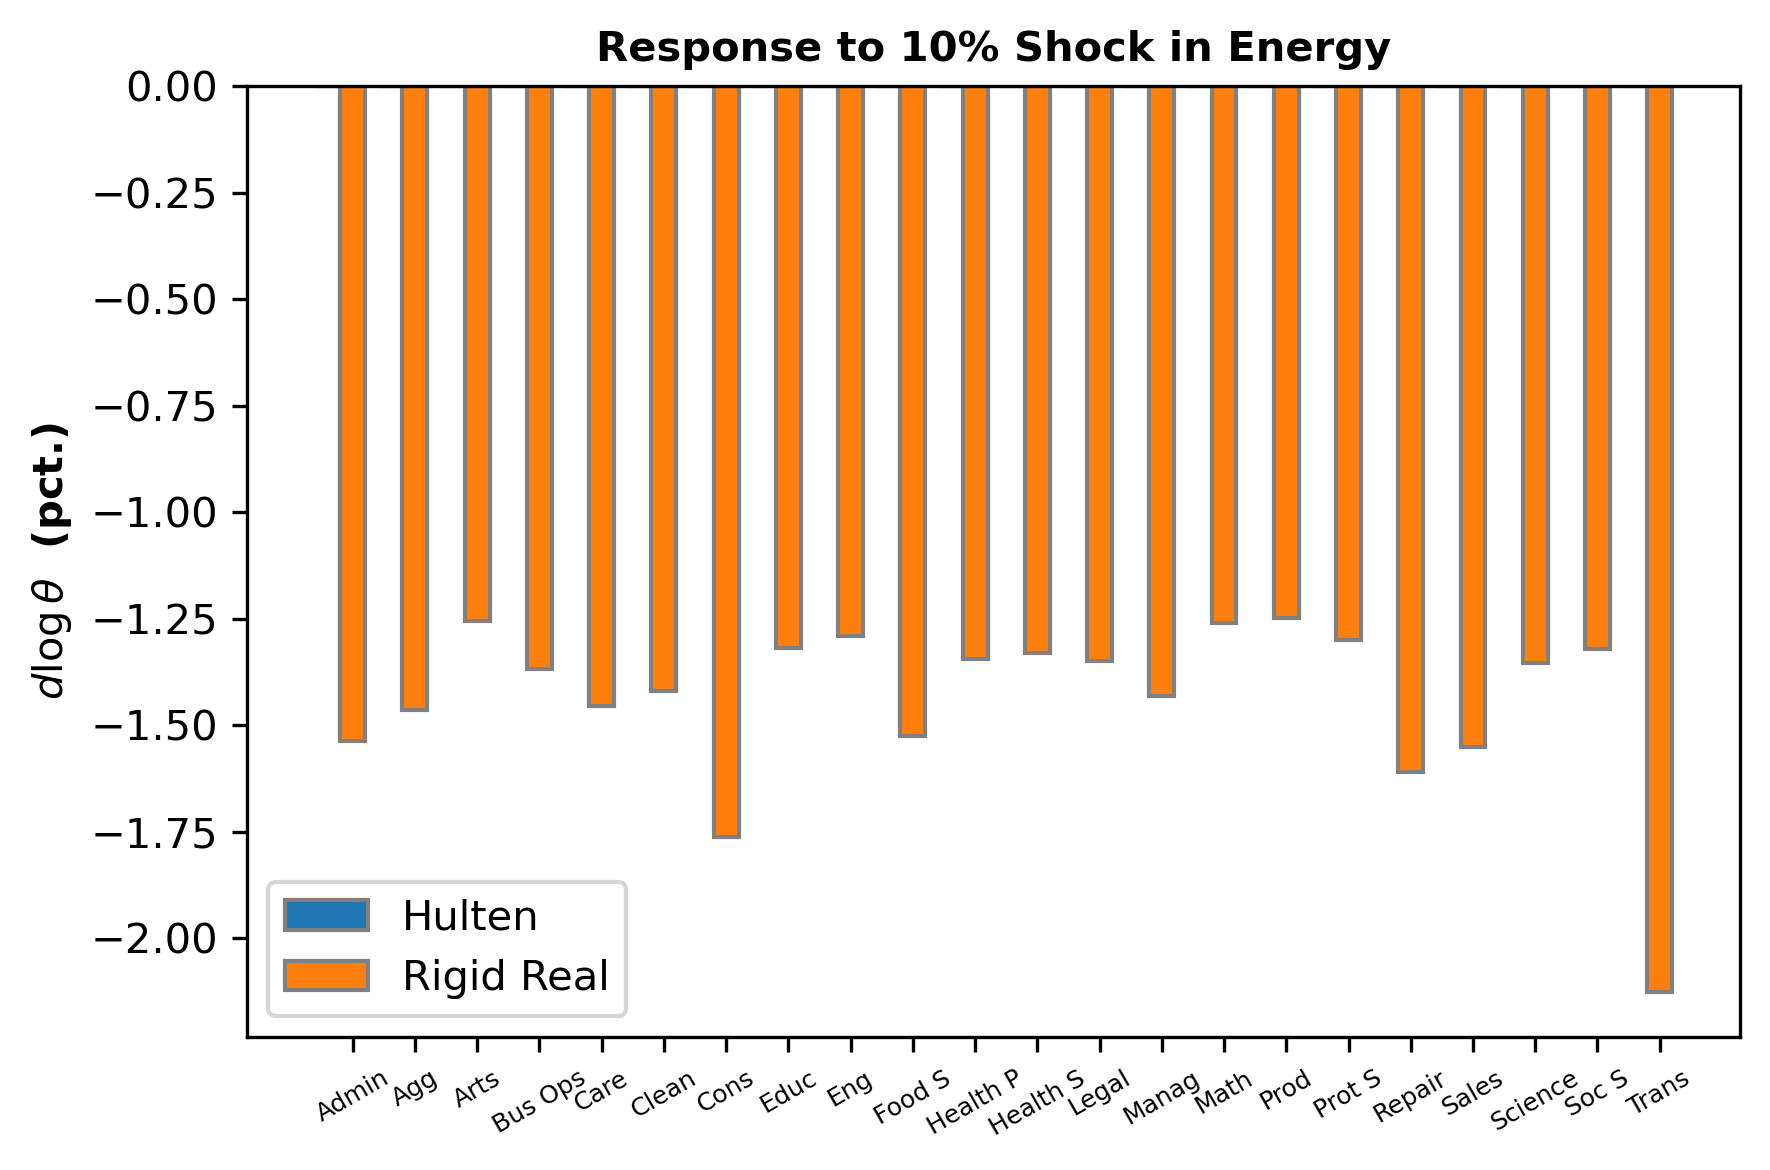

In [11]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_KshockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

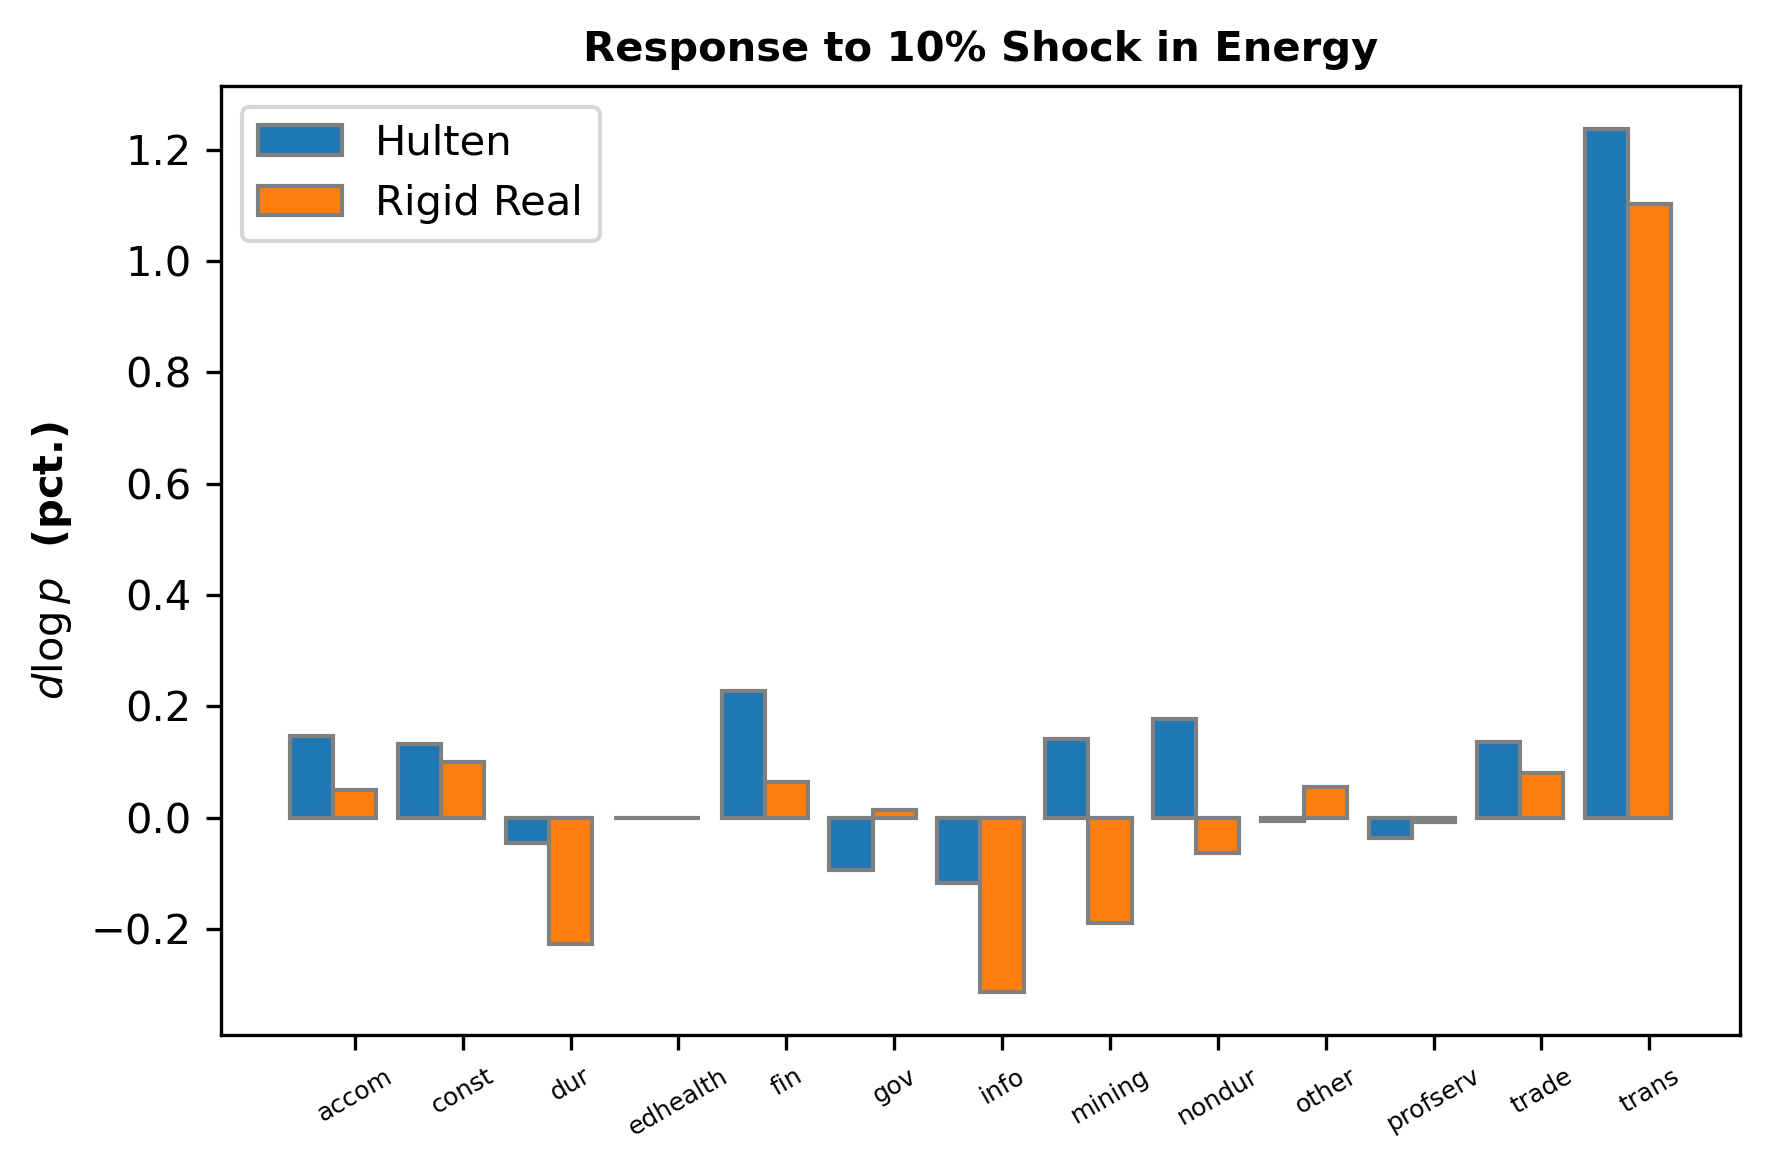

In [12]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_KshockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

## Labor Supply Shocks to Service Sectors

In [13]:
occupation_names

['Admin',
 'Agg',
 'Arts',
 'Bus Ops',
 'Care',
 'Clean',
 'Cons',
 'Educ',
 'Eng',
 'Food S',
 'Health P',
 'Health S',
 'Legal',
 'Manag',
 'Math',
 'Prod',
 'Prot S',
 'Repair',
 'Sales',
 'Science',
 'Soc S',
 'Trans']

In [14]:
occupation_names.index('Care')

4

In [15]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
service_sectors = ['Care', 'Clean', 'Food S', 'Trans']
shock_size = -0.02

for i in service_sectors:
    dlog_H[occupation_names.index(i)] = shock_size
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
secT_vec = np.zeros((J, len(PriceAssumption)))

occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [16]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [17]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [18]:
np.multiply(dlog_theta.T, epsN_norm).shape

(13, 22)

In [19]:
np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1).shape

(13, 1)

In [20]:
epsN_norm[0, :]

array([4.34691670e-02, 3.16282806e-04, 2.44006371e-02, 2.15834194e-02,
       5.05546676e-02, 4.12221593e-02, 1.22011223e-03, 4.94621212e-03,
       3.28798077e-04, 6.22194023e-01, 1.50035597e-03, 8.92226917e-04,
       2.79215268e-04, 9.07721586e-02, 2.18710905e-03, 7.05521582e-03,
       1.09159248e-02, 1.89831374e-02, 3.71328184e-02, 3.40888390e-04,
       1.40323233e-04, 1.95651471e-02])

In [21]:
np.multiply(dlog_theta.T, epsN_norm[0, :])

matrix([[-7.49997200e-07, -5.63404169e-09, -4.02417626e-07,
         -3.44451207e-07,  1.62371302e-03,  1.31157144e-03,
         -1.98511113e-08, -7.60024545e-08, -5.17994909e-09,
          2.06442215e-02, -2.37031512e-08, -1.38858677e-08,
         -4.97854782e-09, -1.54526172e-06, -3.38231170e-08,
         -9.56492675e-08, -1.94128036e-07, -3.51440355e-07,
         -6.83965915e-07, -5.78378446e-09, -2.29644083e-09,
          6.58540554e-04]])

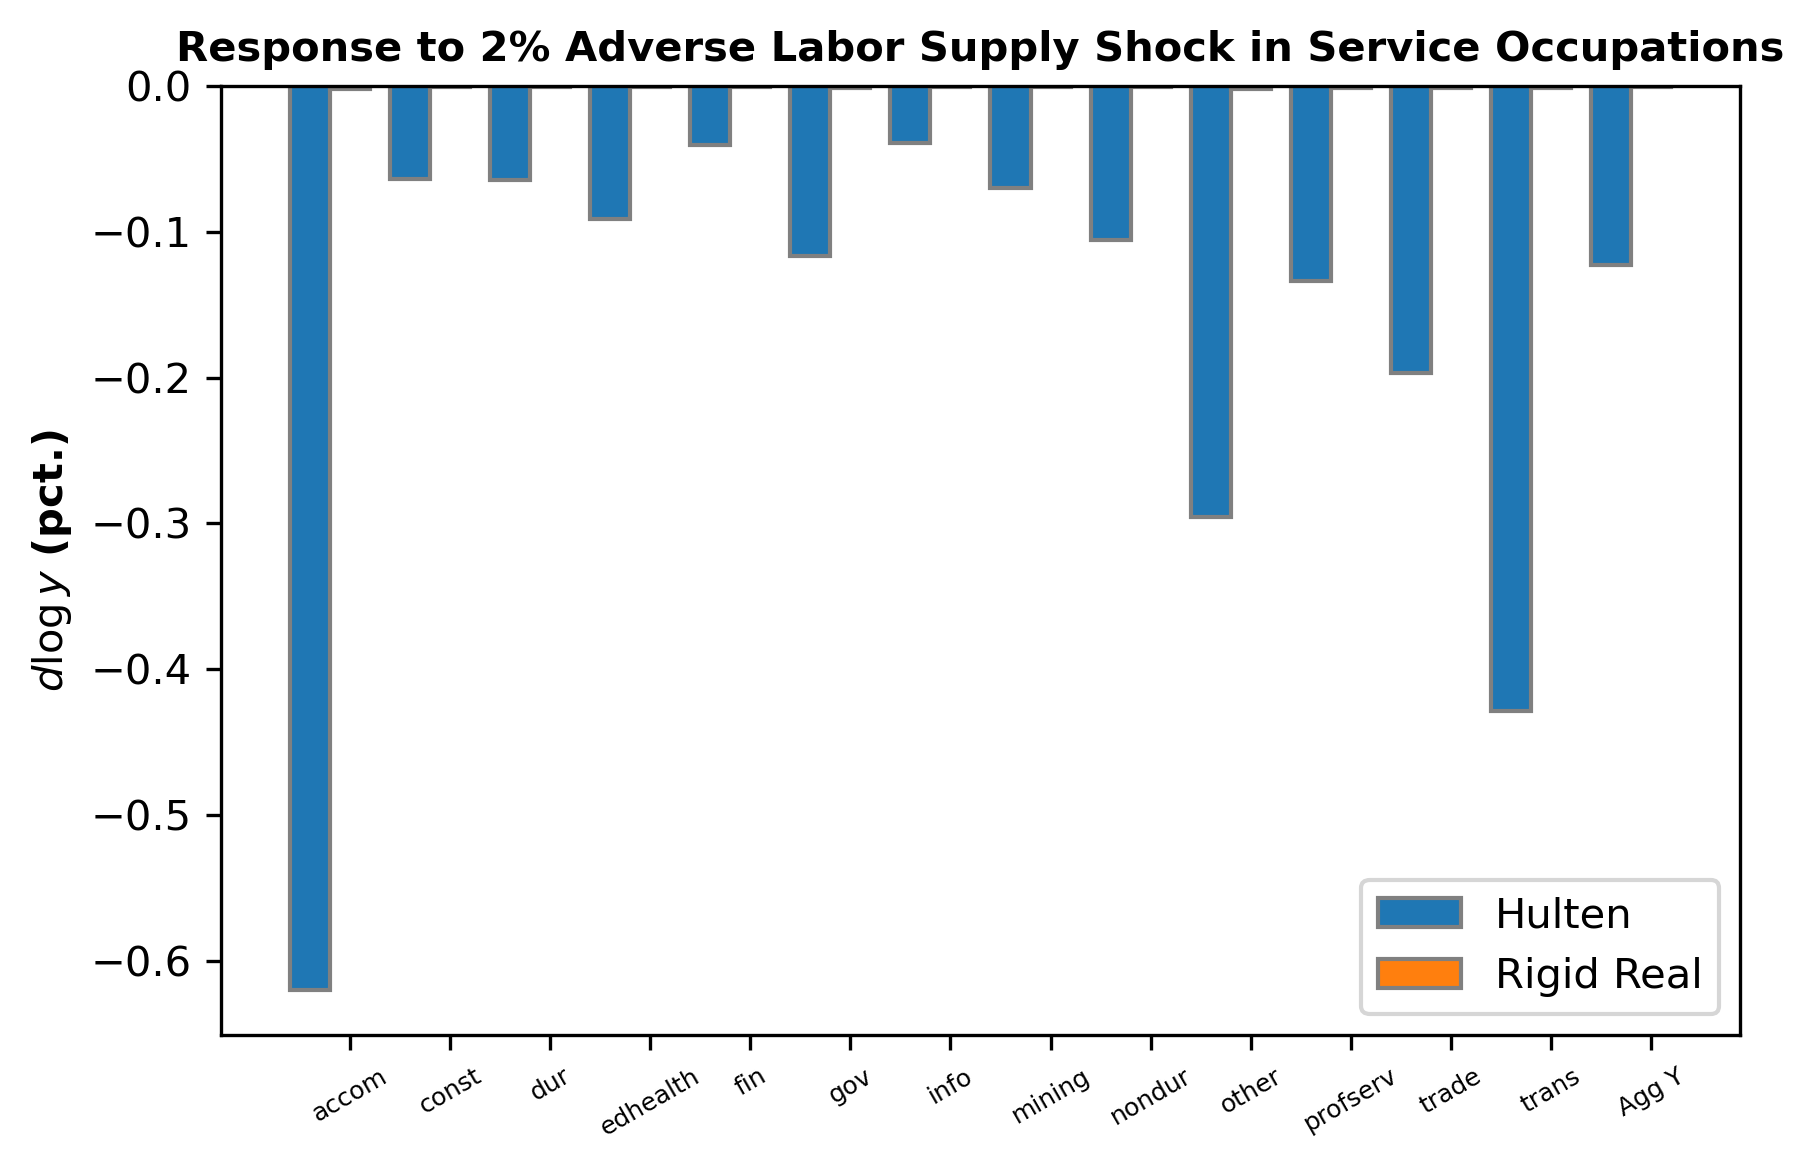

In [22]:
title = f'Response to 2% Adverse Labor Supply Shock in Service Occupations'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HservshockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

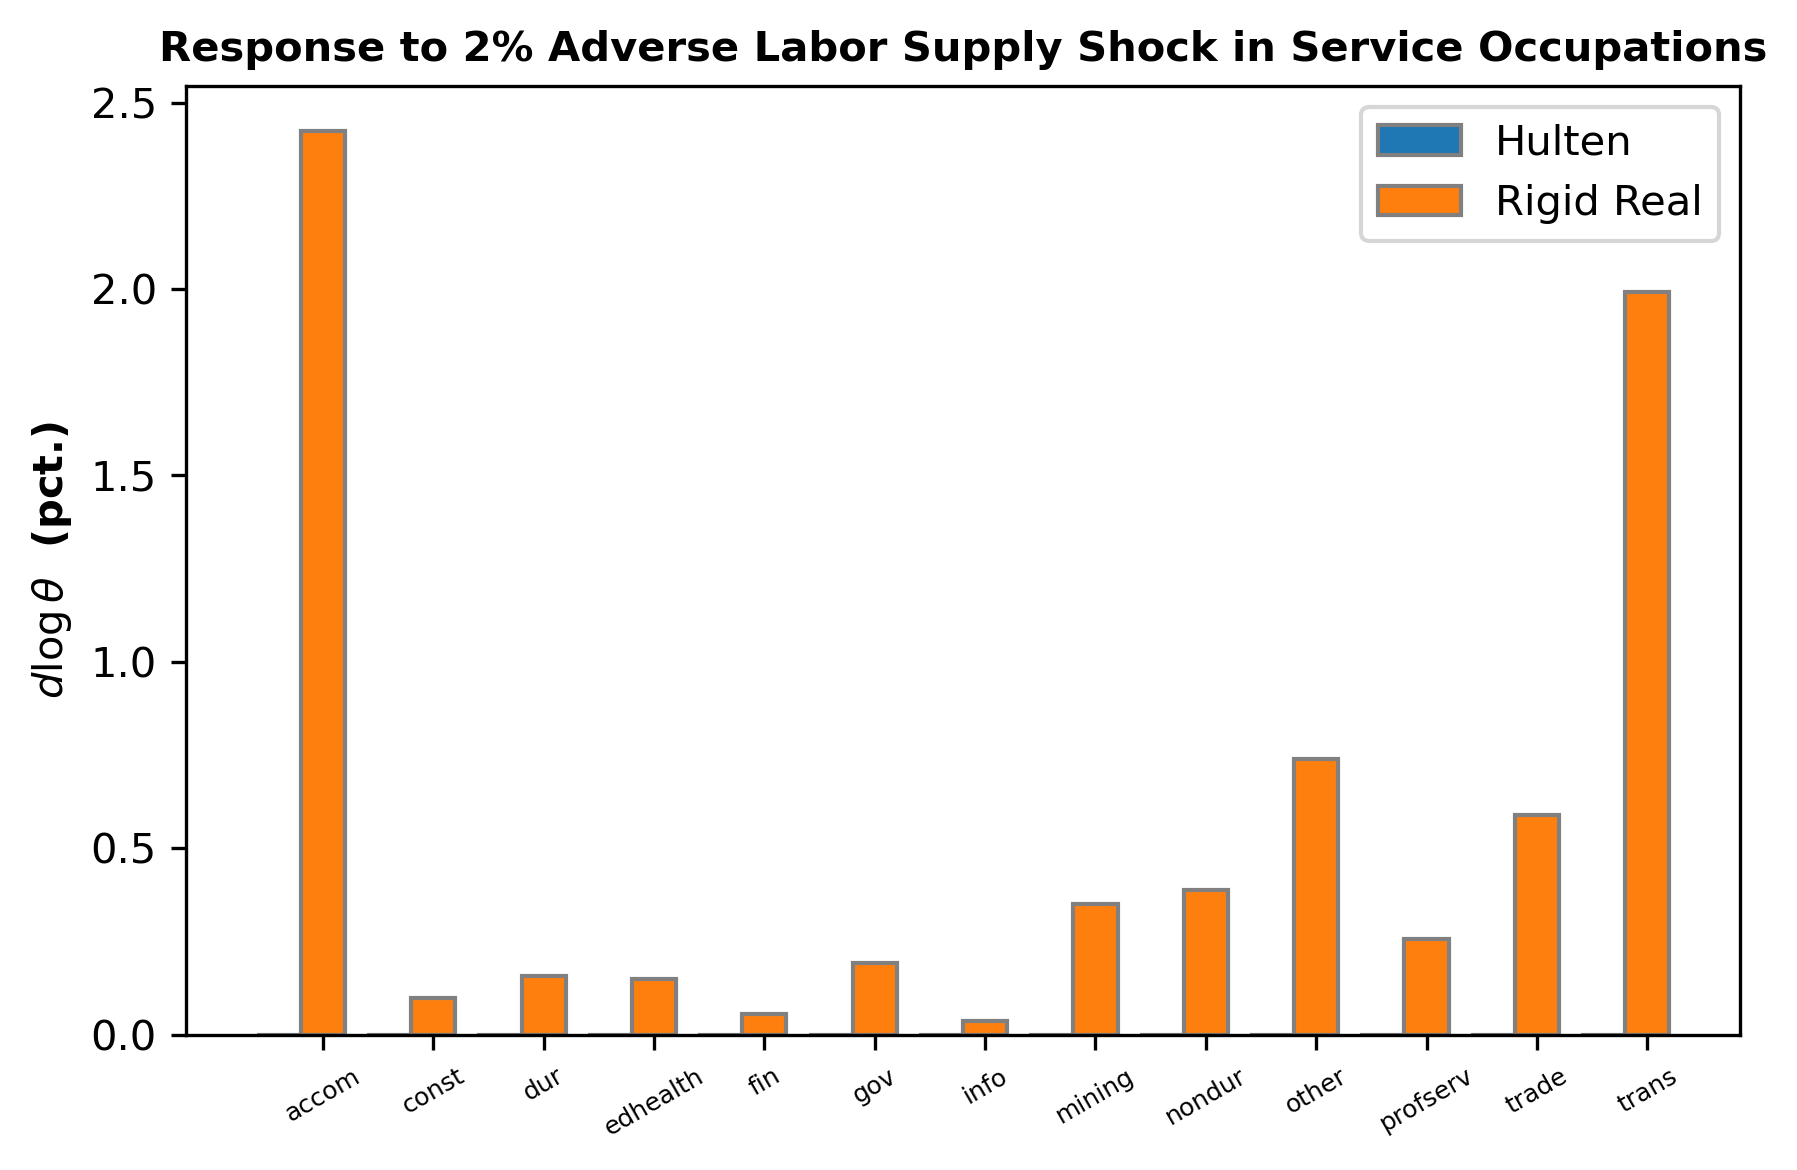

In [23]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HservshockTsec.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth=0.40, dpi=300)

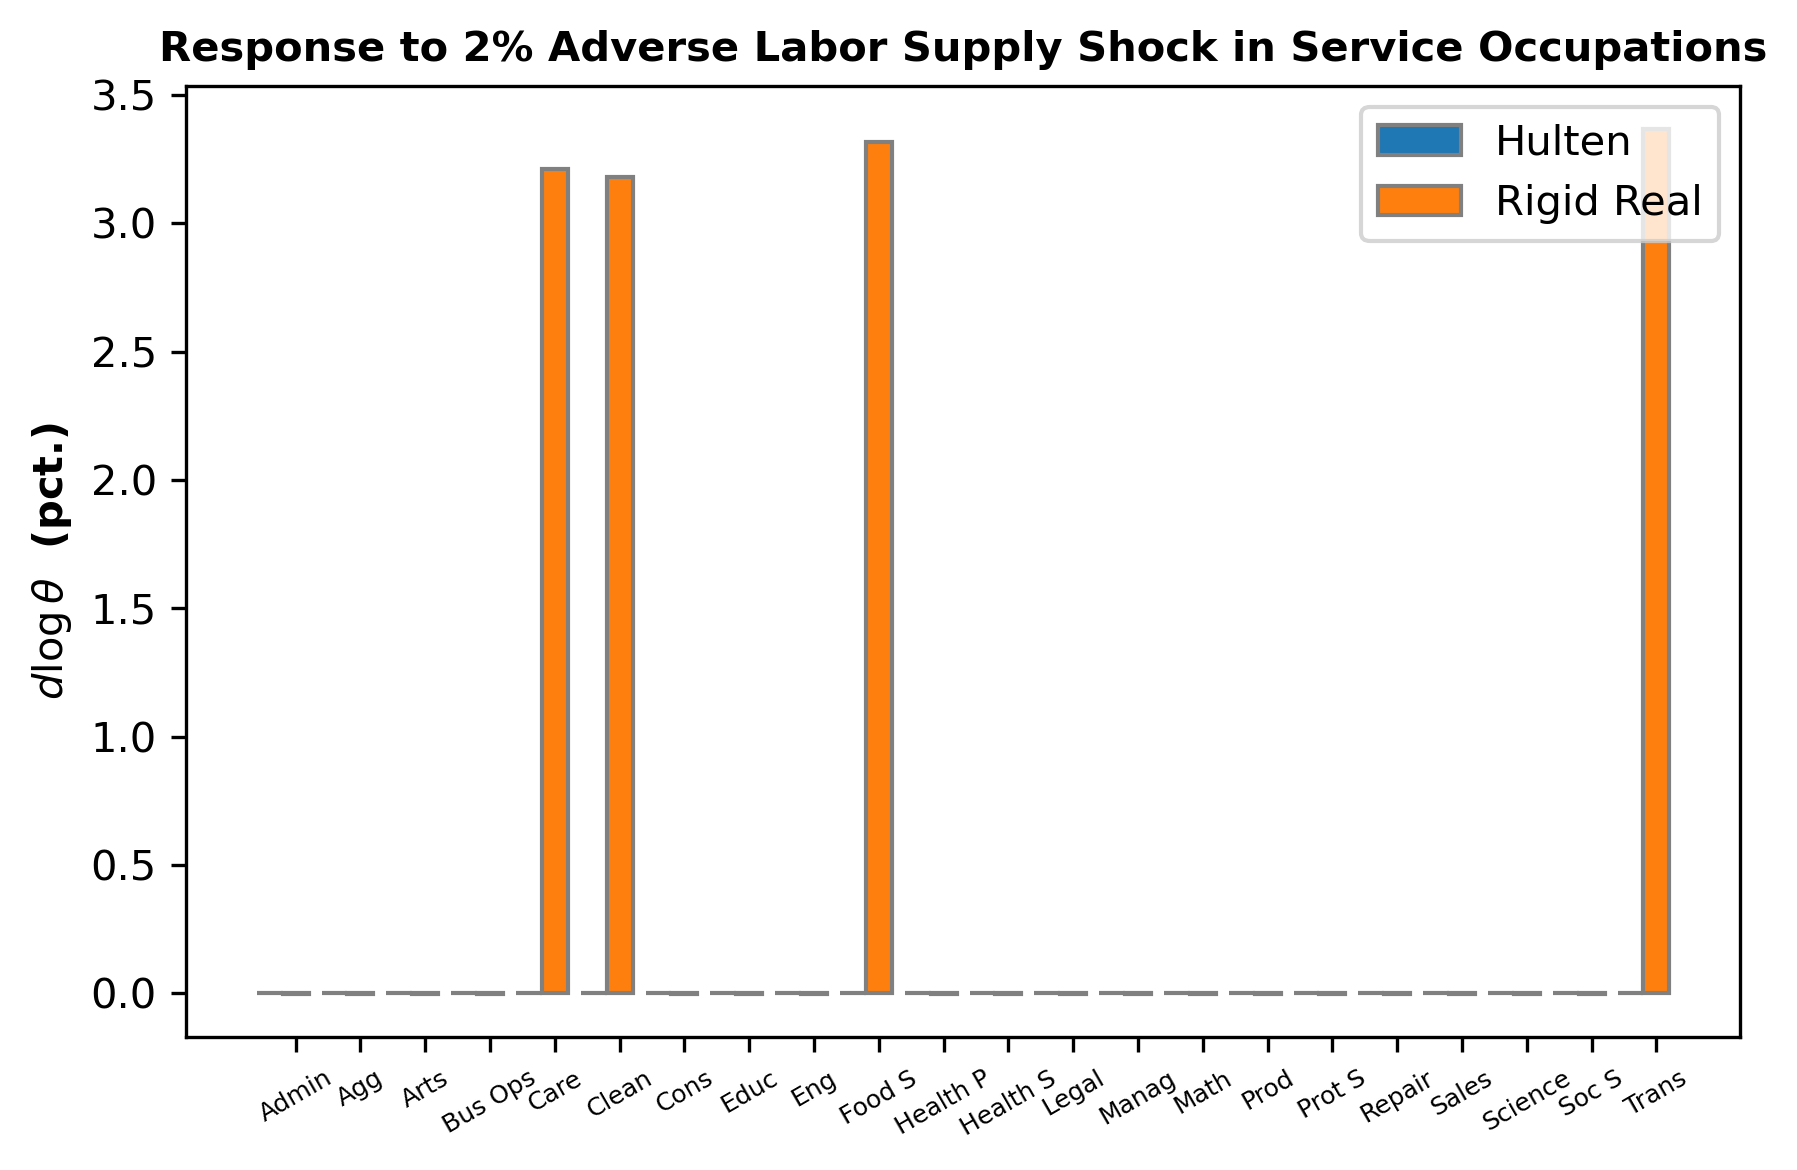

In [24]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HservshockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

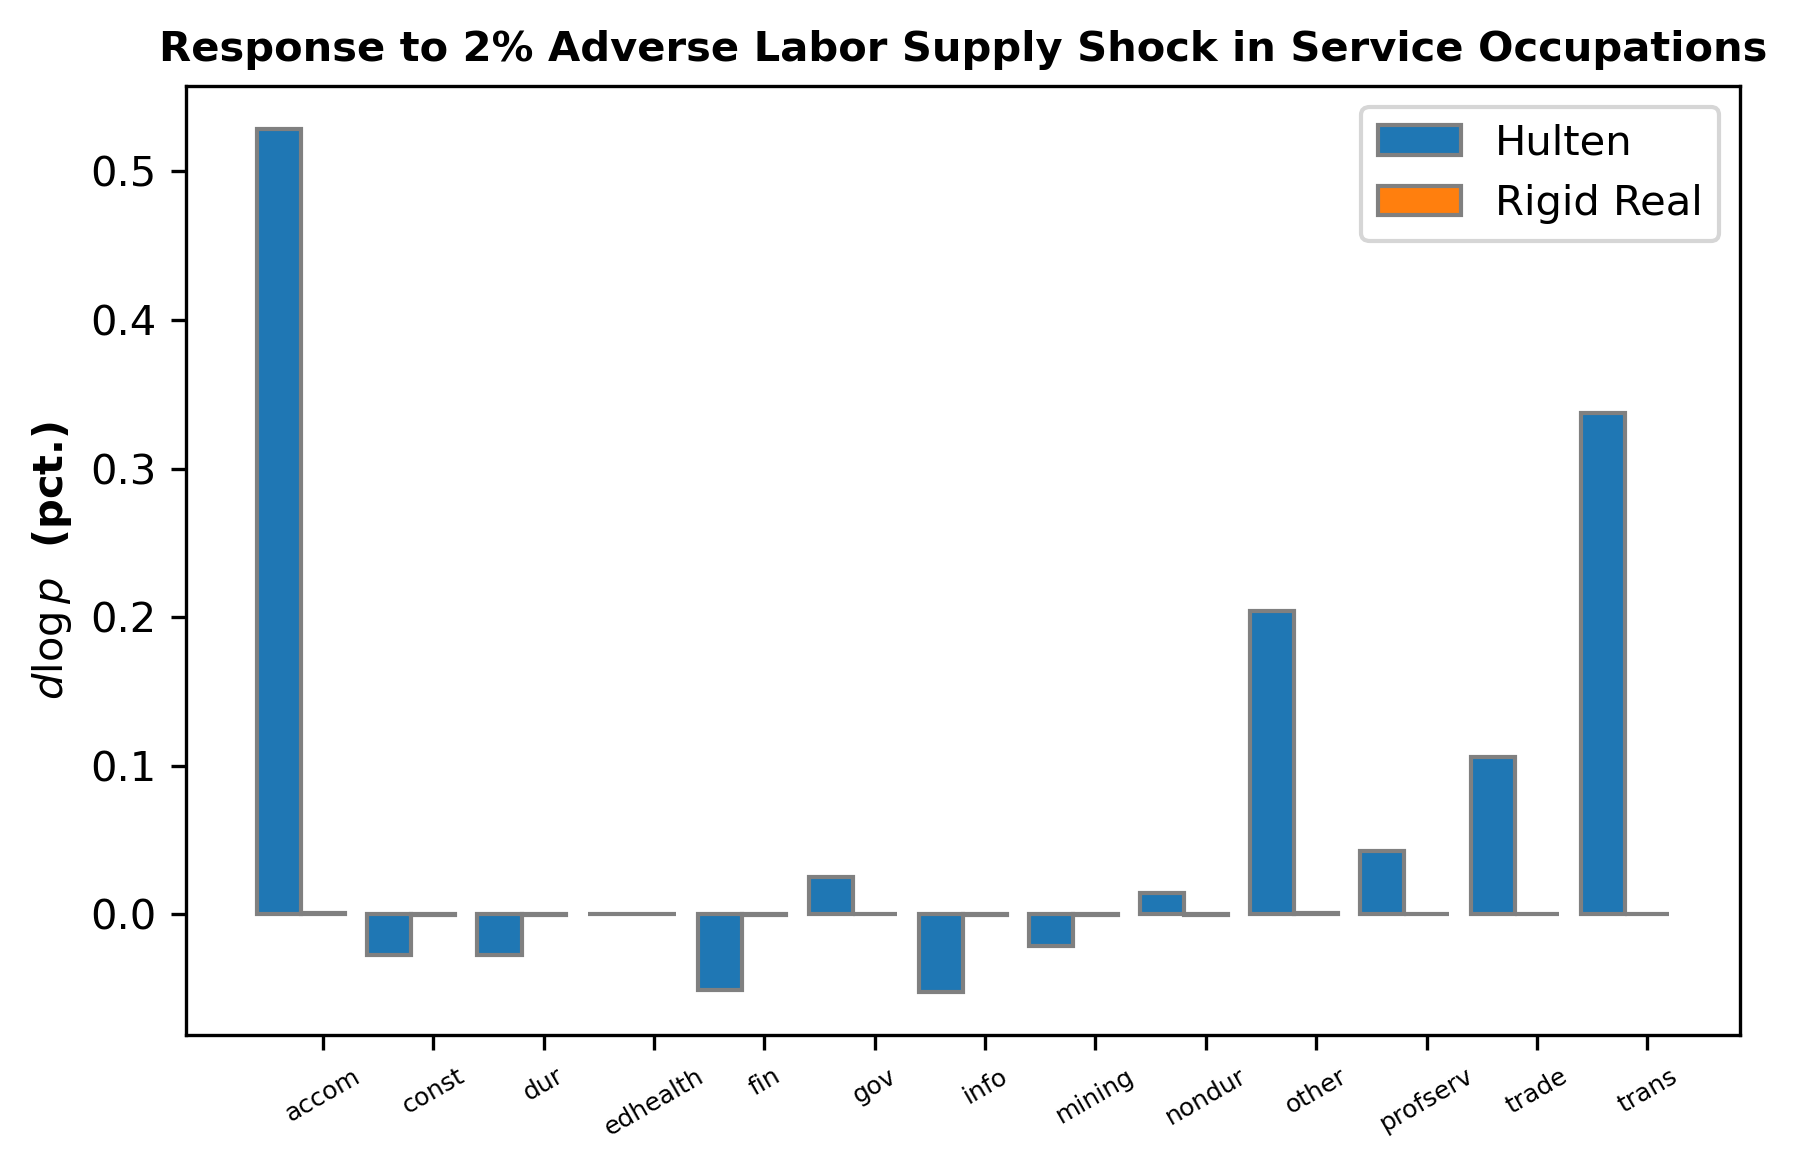

In [25]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HservshockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

## Calibration figures: Response to Labor Supply Shock

### Aggregate importance of deviations from Hulten.

To analyse the quantitative importance of deviations from Hulten's theorem, below we vary $\gamma_A$ from 0 to 2, and plot the aggregate response to a 1\% shock to durable goods.

In [26]:
dlog_A = np.zeros((J, 1))
dlog_H = np.ones((O, 1)) * -0.02
dlog_K = np.zeros((K, 1))
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
secT_vec = np.zeros((J, len(PriceAssumption))) 
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [27]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [28]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [29]:
sectorY_vec.shape

(14, 2)

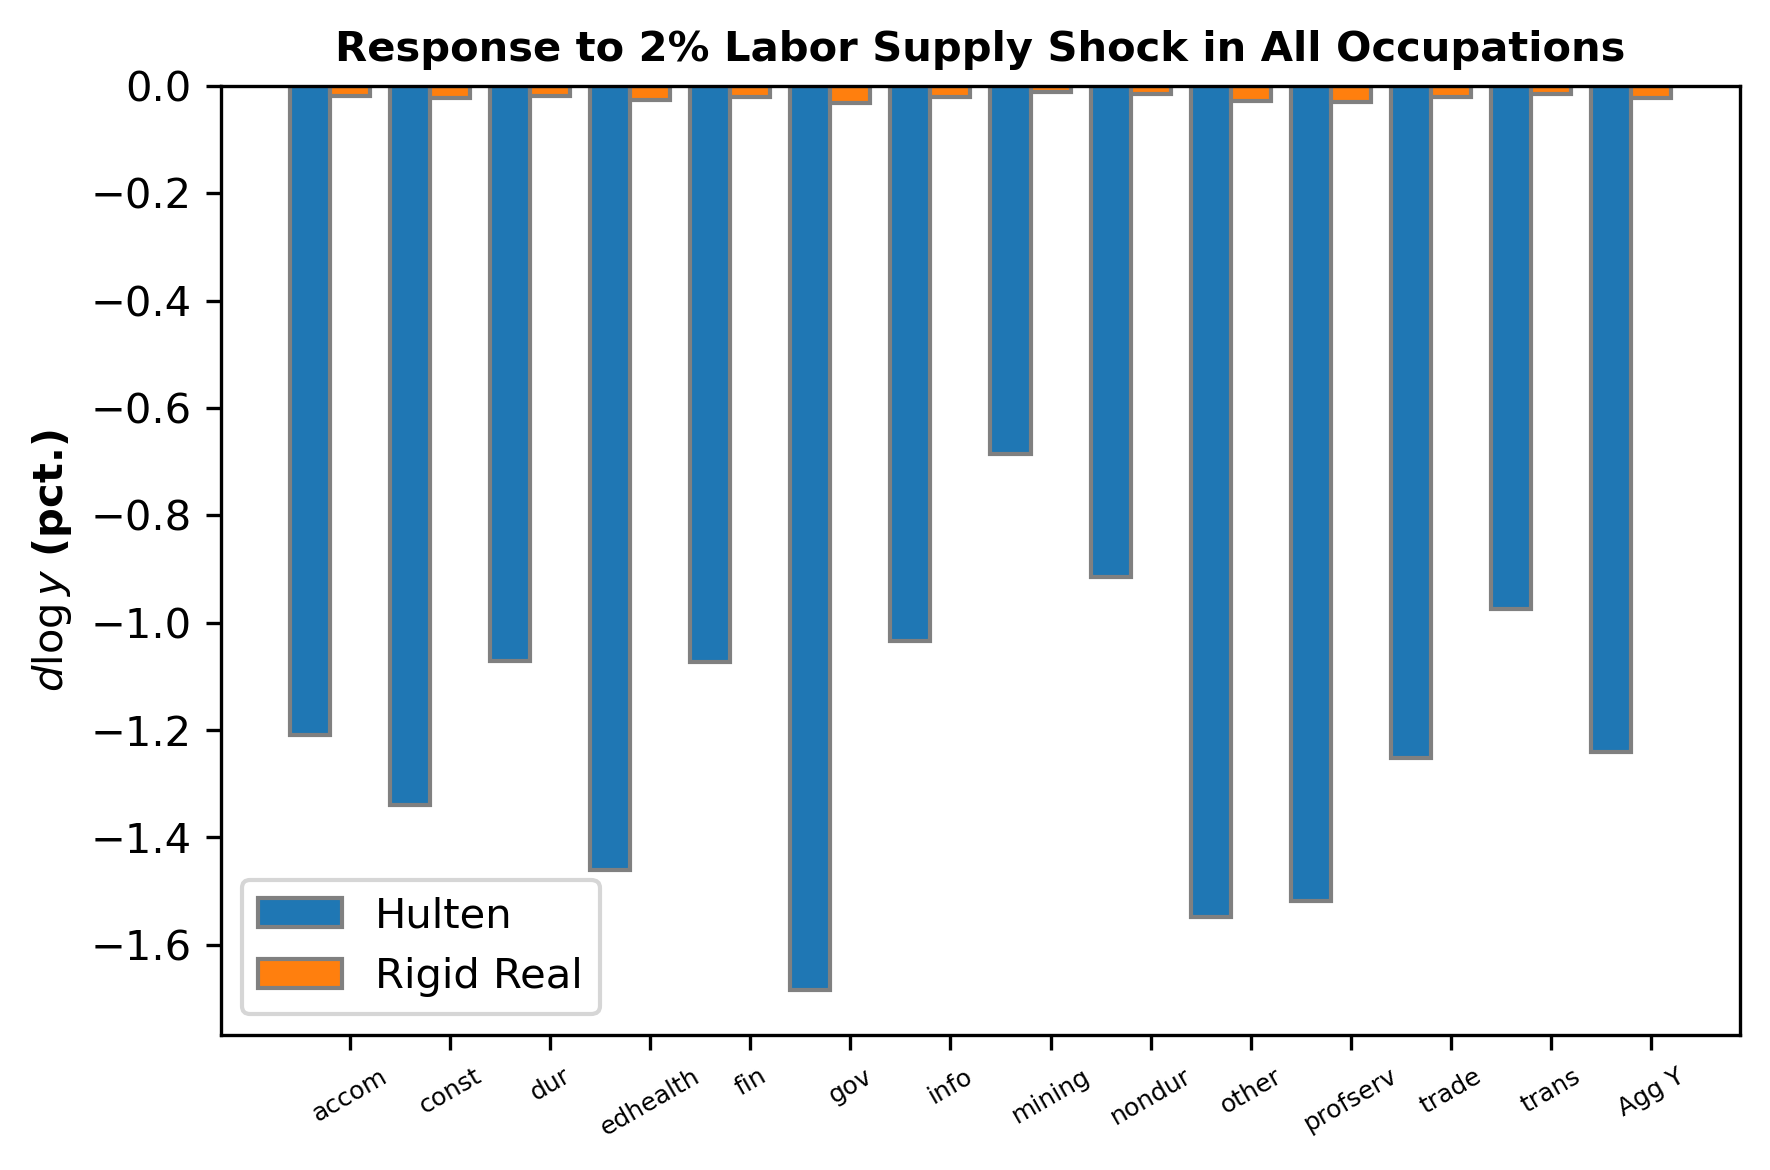

In [30]:
title = f'Response to 2% Labor Supply Shock in All Occupations'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HallshockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

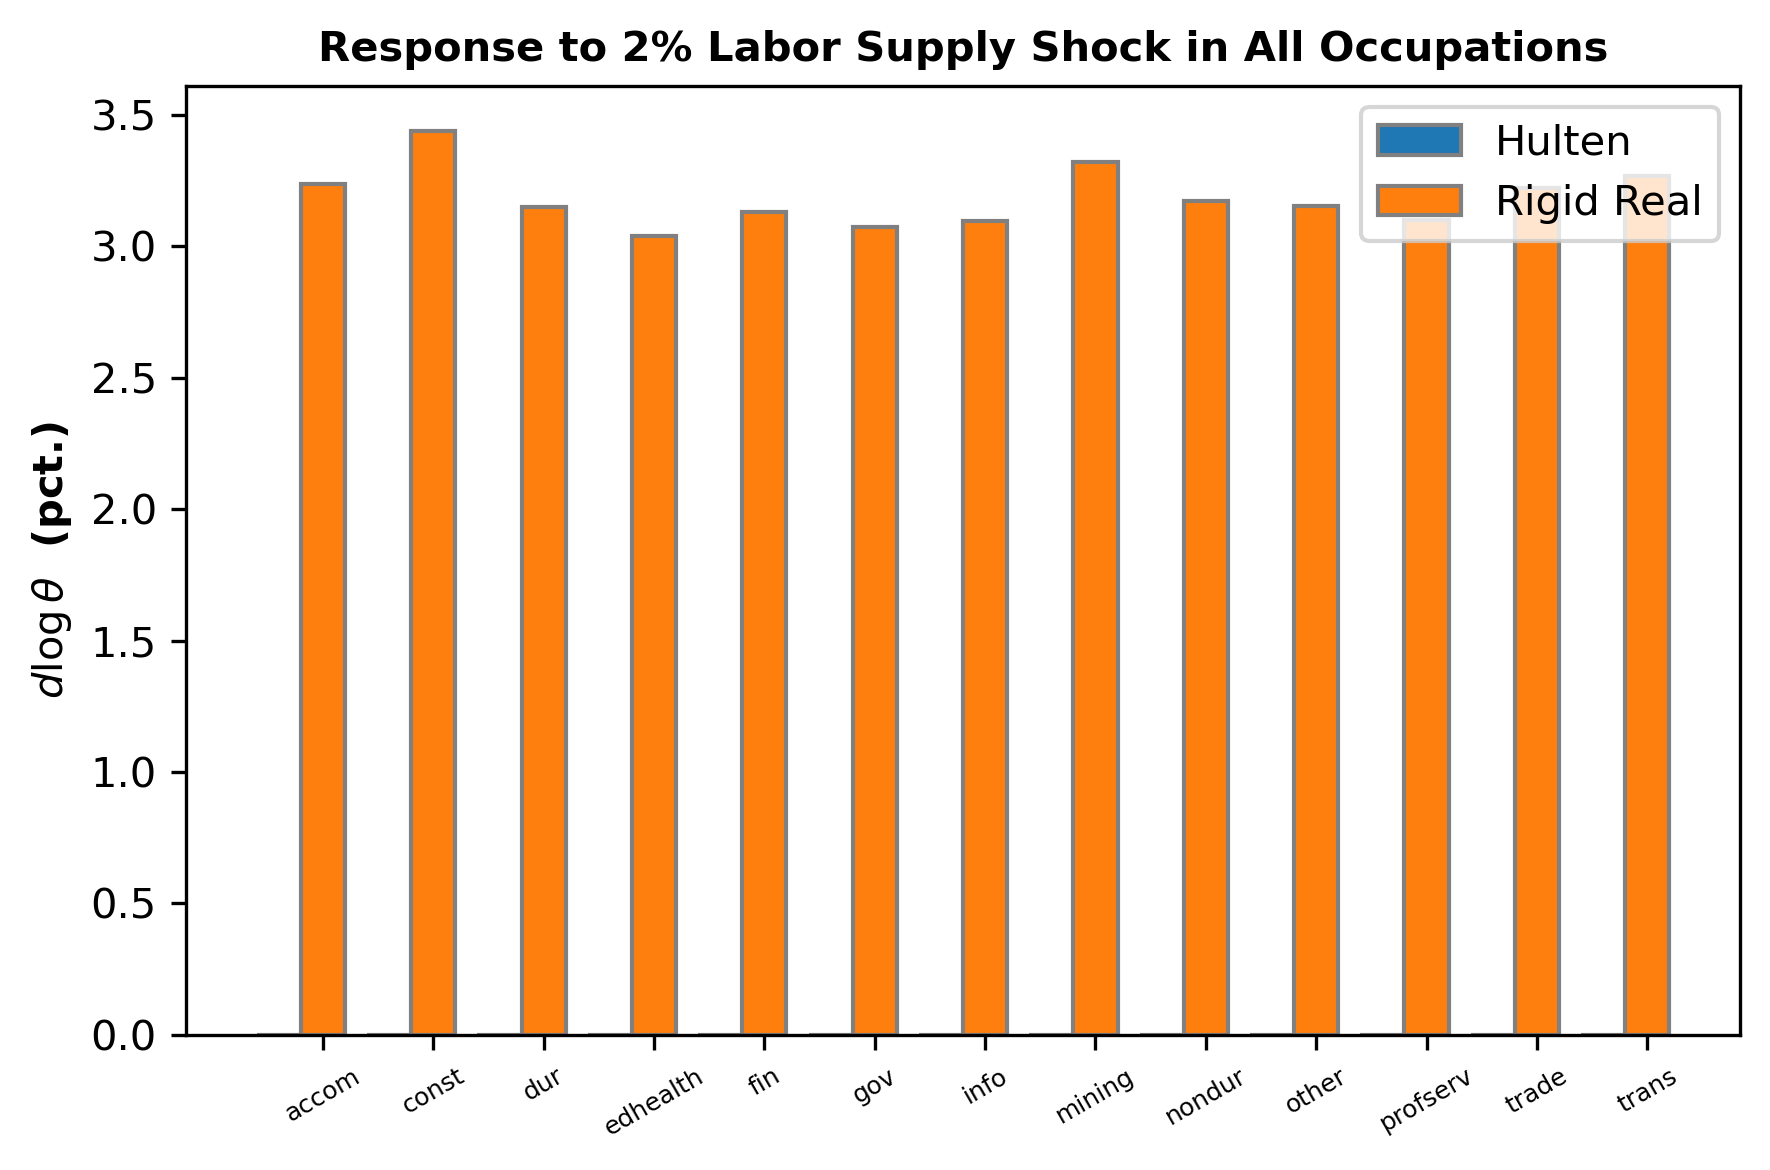

In [31]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HallshockTsec.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

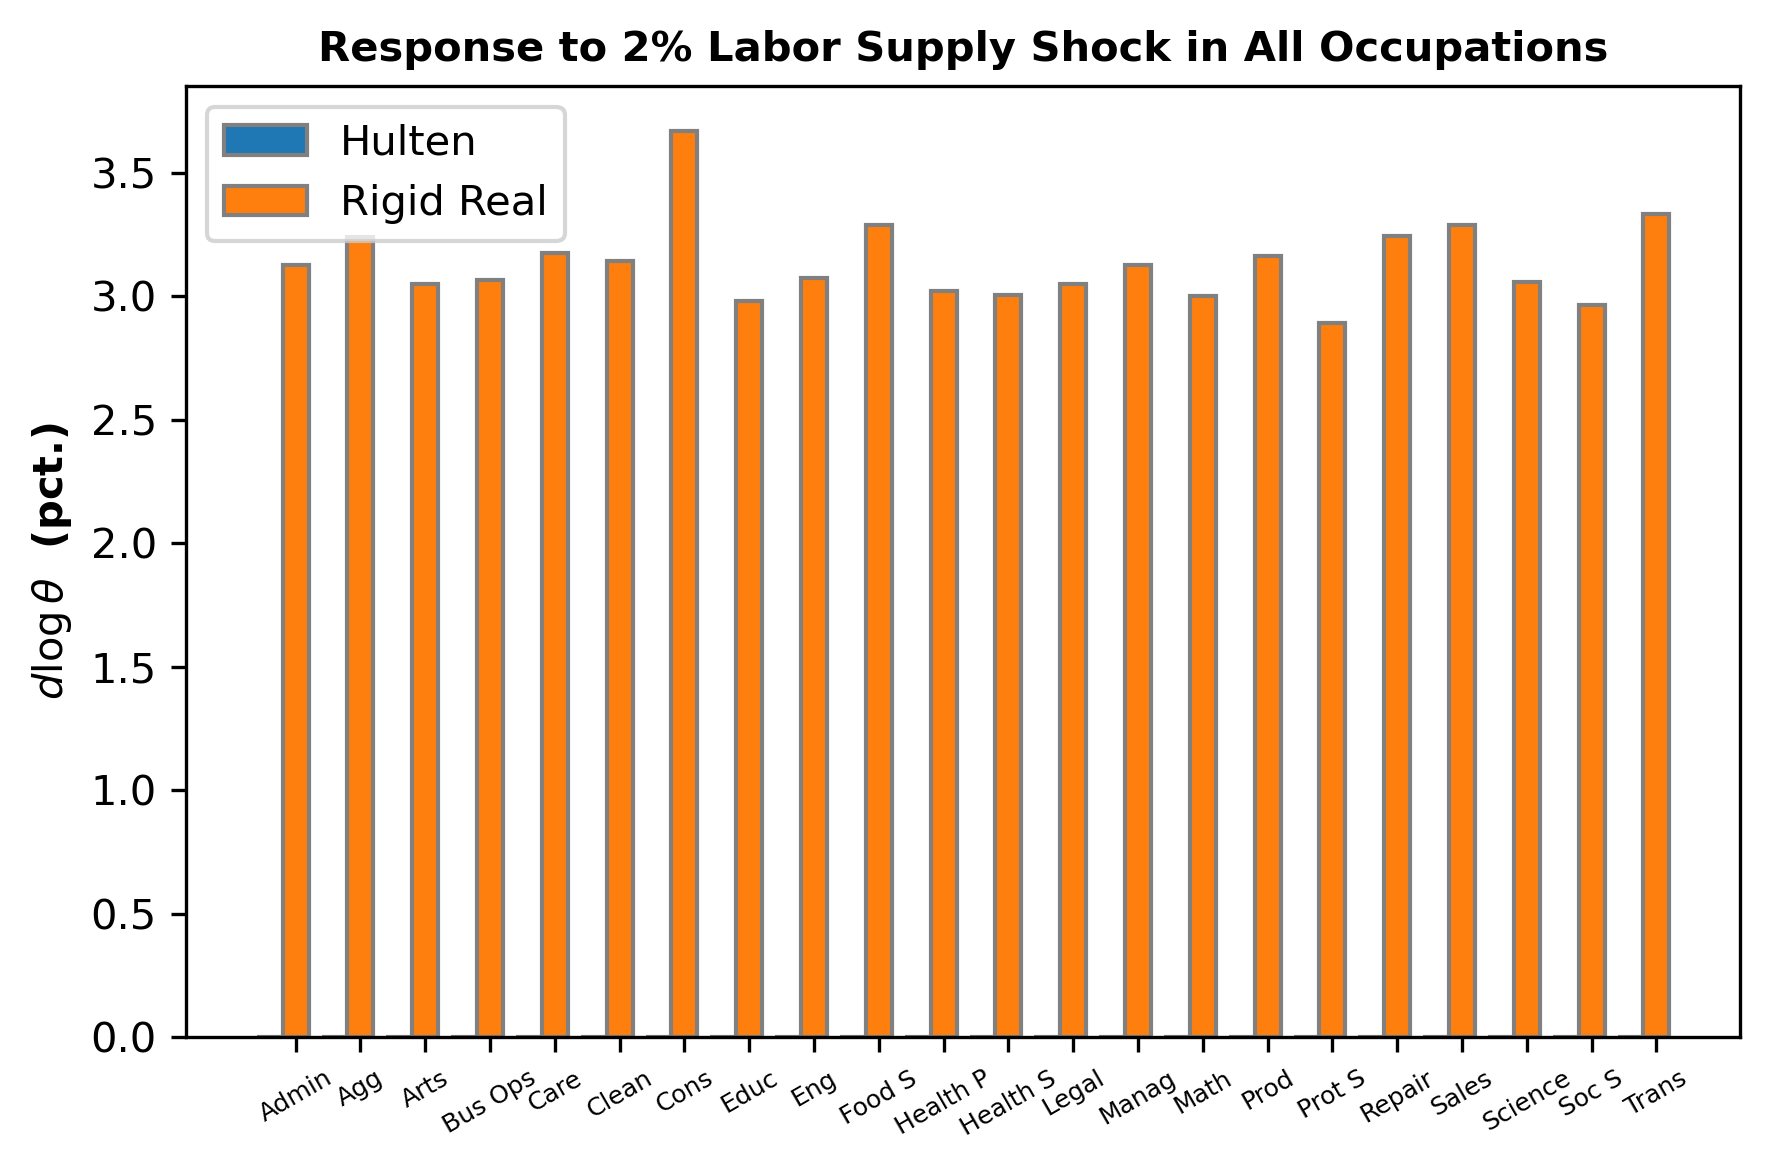

In [32]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HallshockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

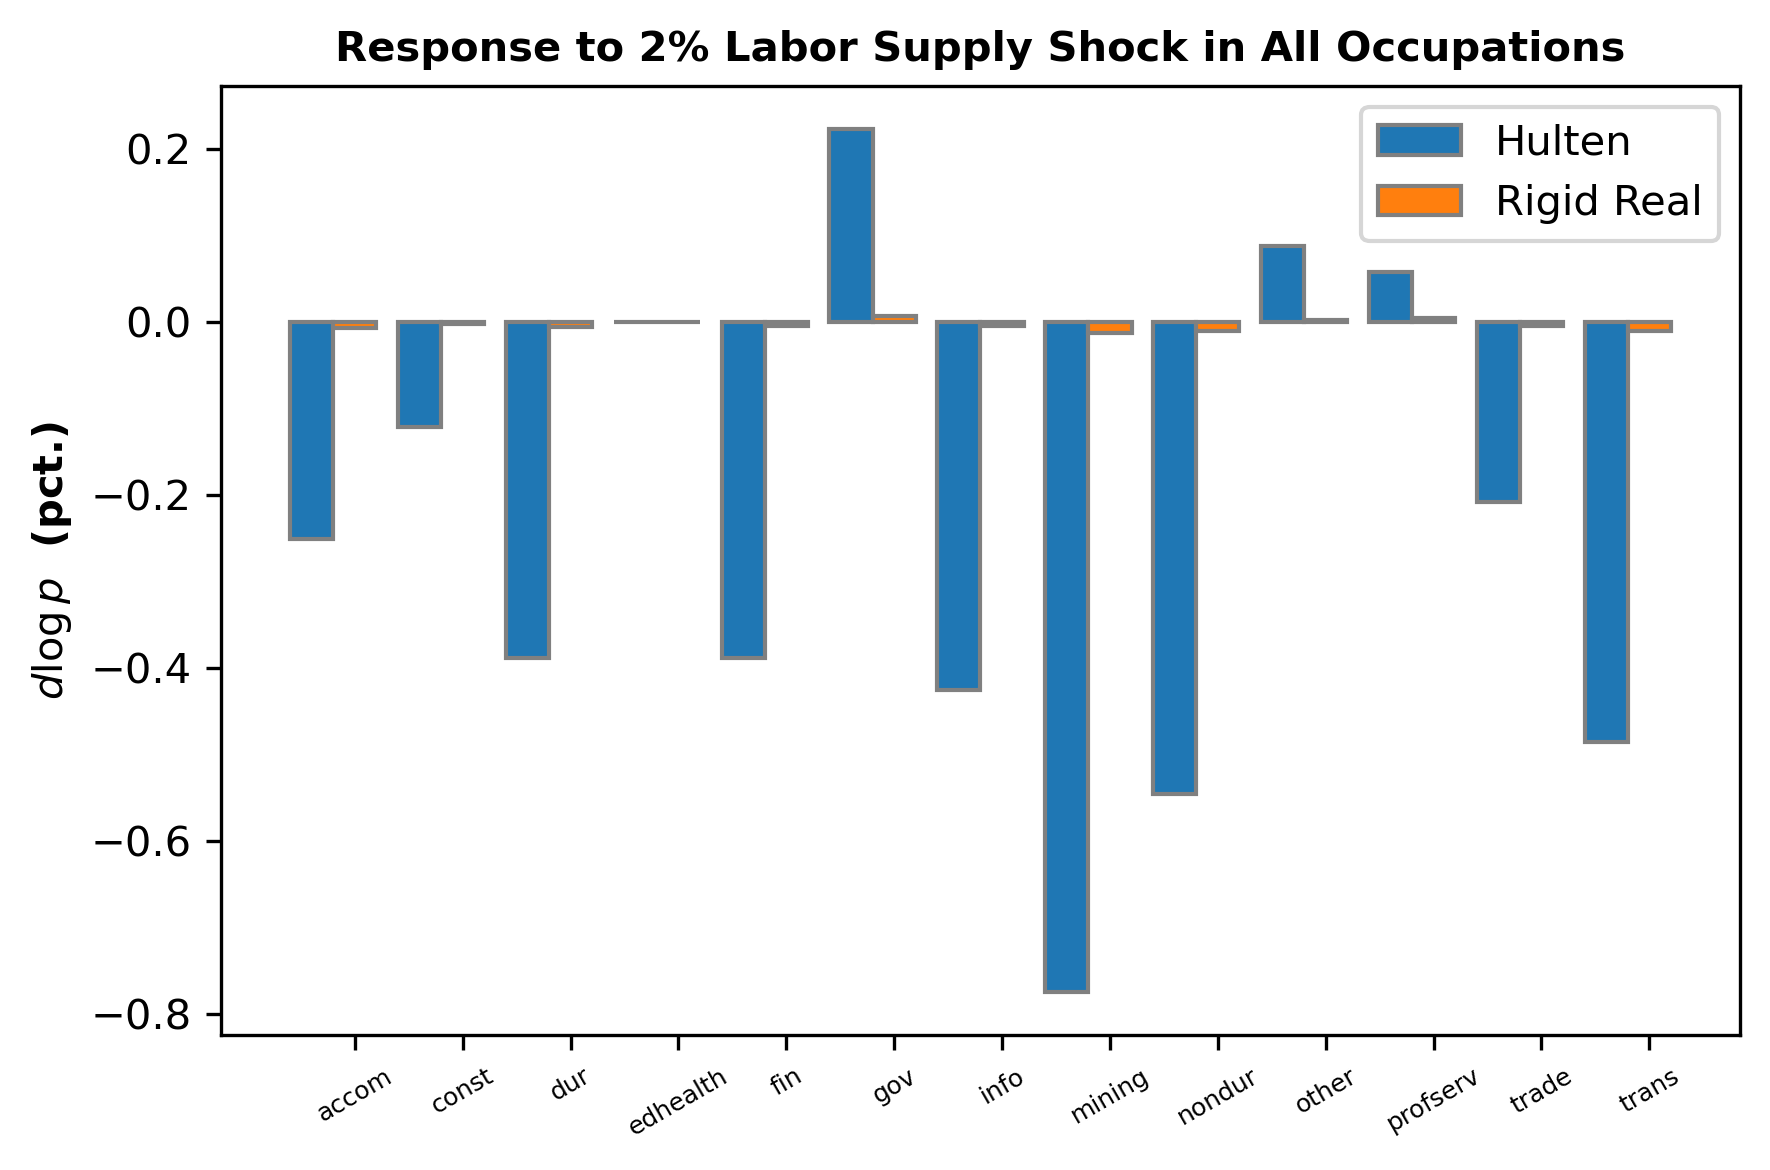

In [33]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HallshockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

# Combination Shocks

In [34]:
dlog_A = np.zeros((J, 1))
dlog_H = np.ones((O, 1)) * -0.02
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.1
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', 'Rigid Real']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
secT_vec = np.zeros((J,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [35]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [36]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    dlog_theta_sec = np.sum(np.multiply(dlog_theta.T, epsN_norm), axis=1)
    secT_vec[:, i] = dlog_theta_sec.flatten()
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [37]:
sectorY_vec.shape

(14, 2)

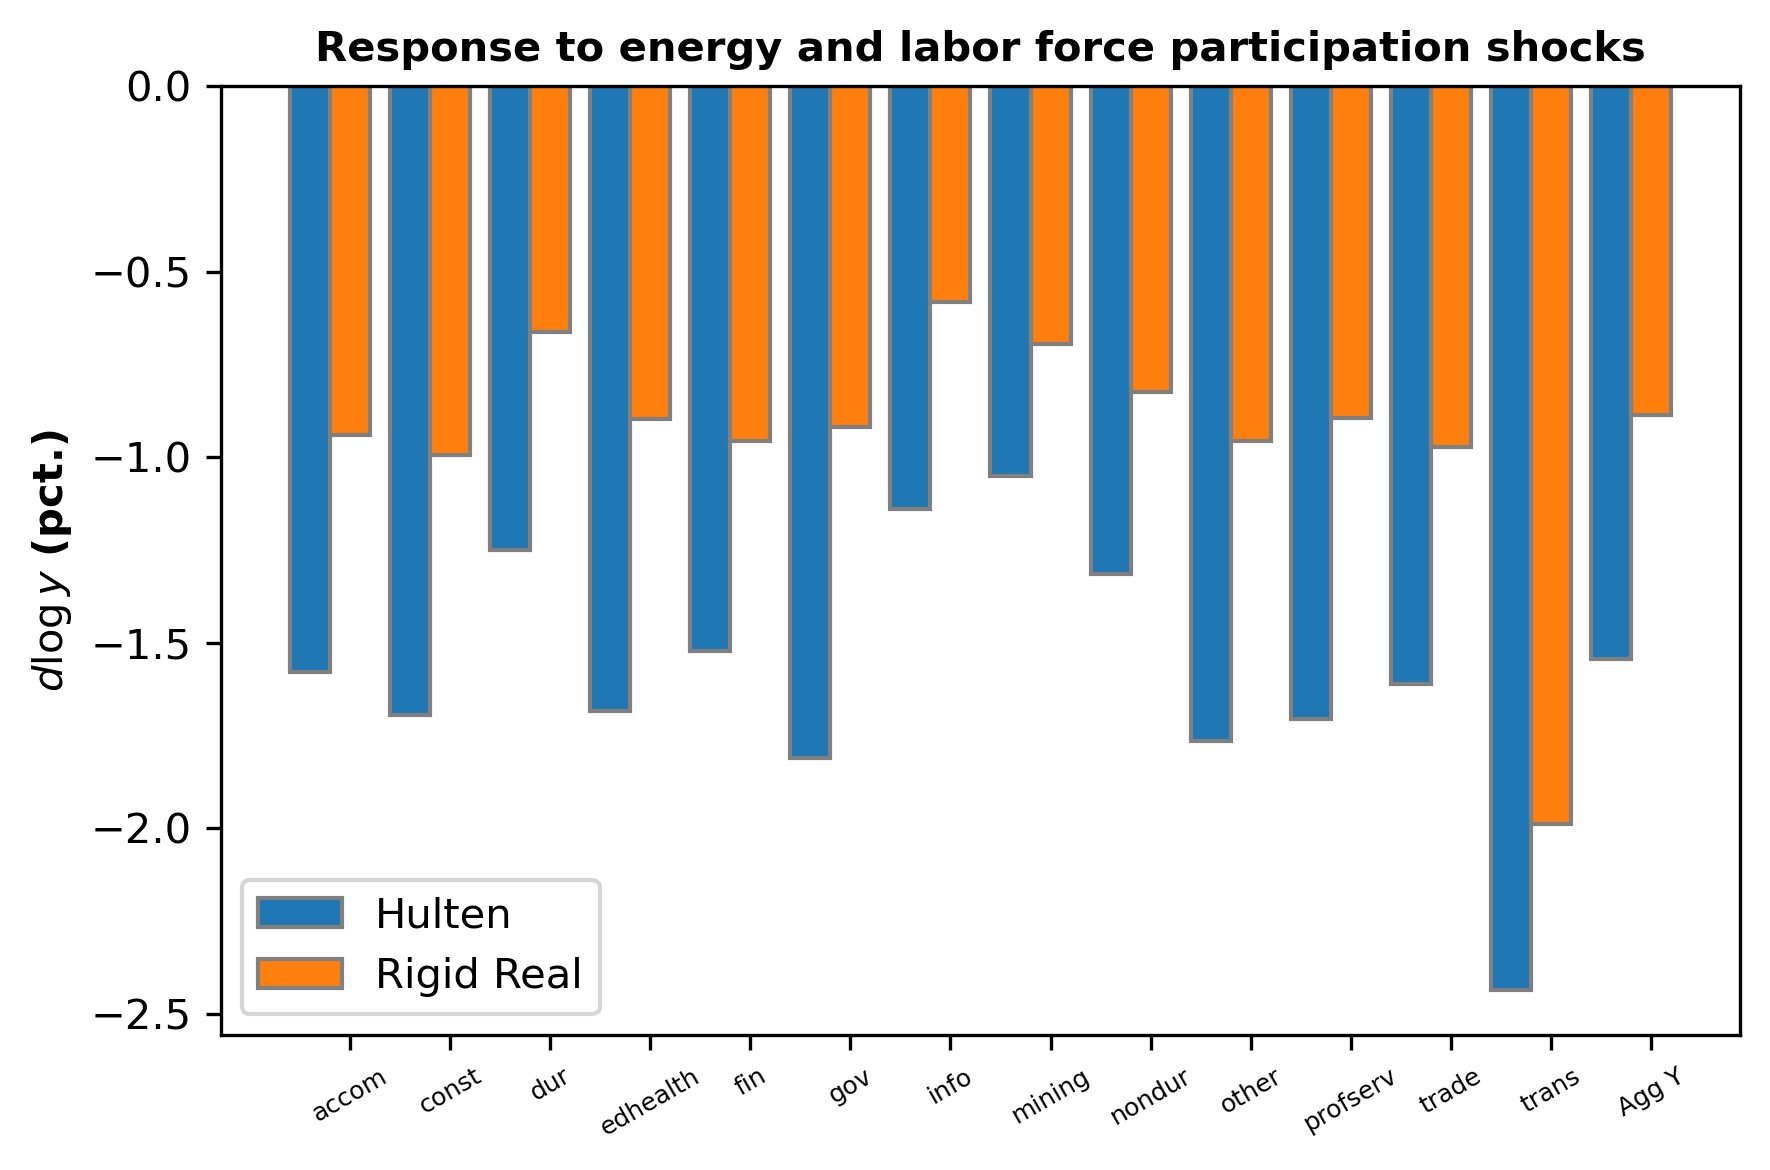

In [38]:
title = f'Response to energy and labor force participation shocks'
xlab = ''
ylab = '$d\log y$ (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HKshockY.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

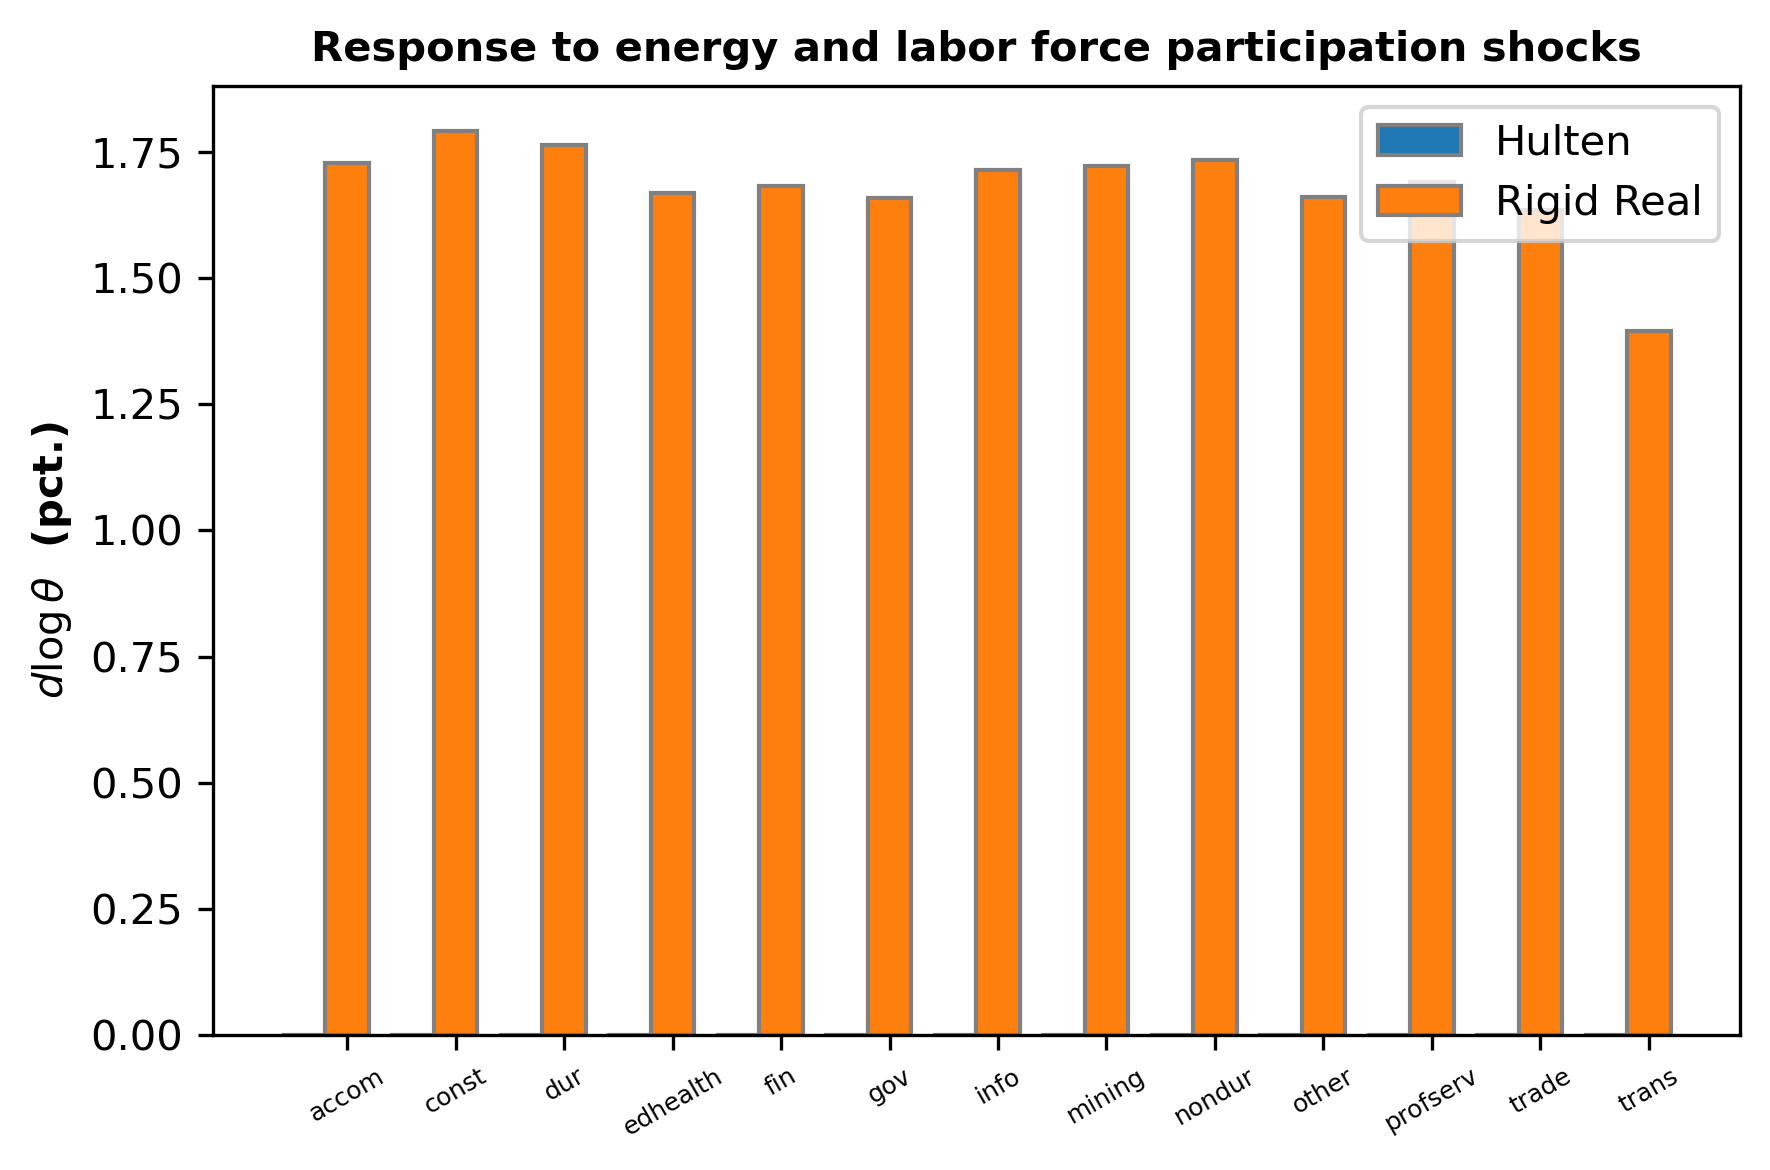

In [39]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HKshockTsec.png'
labels = PriceAssumption
bar_plot(100*secT_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

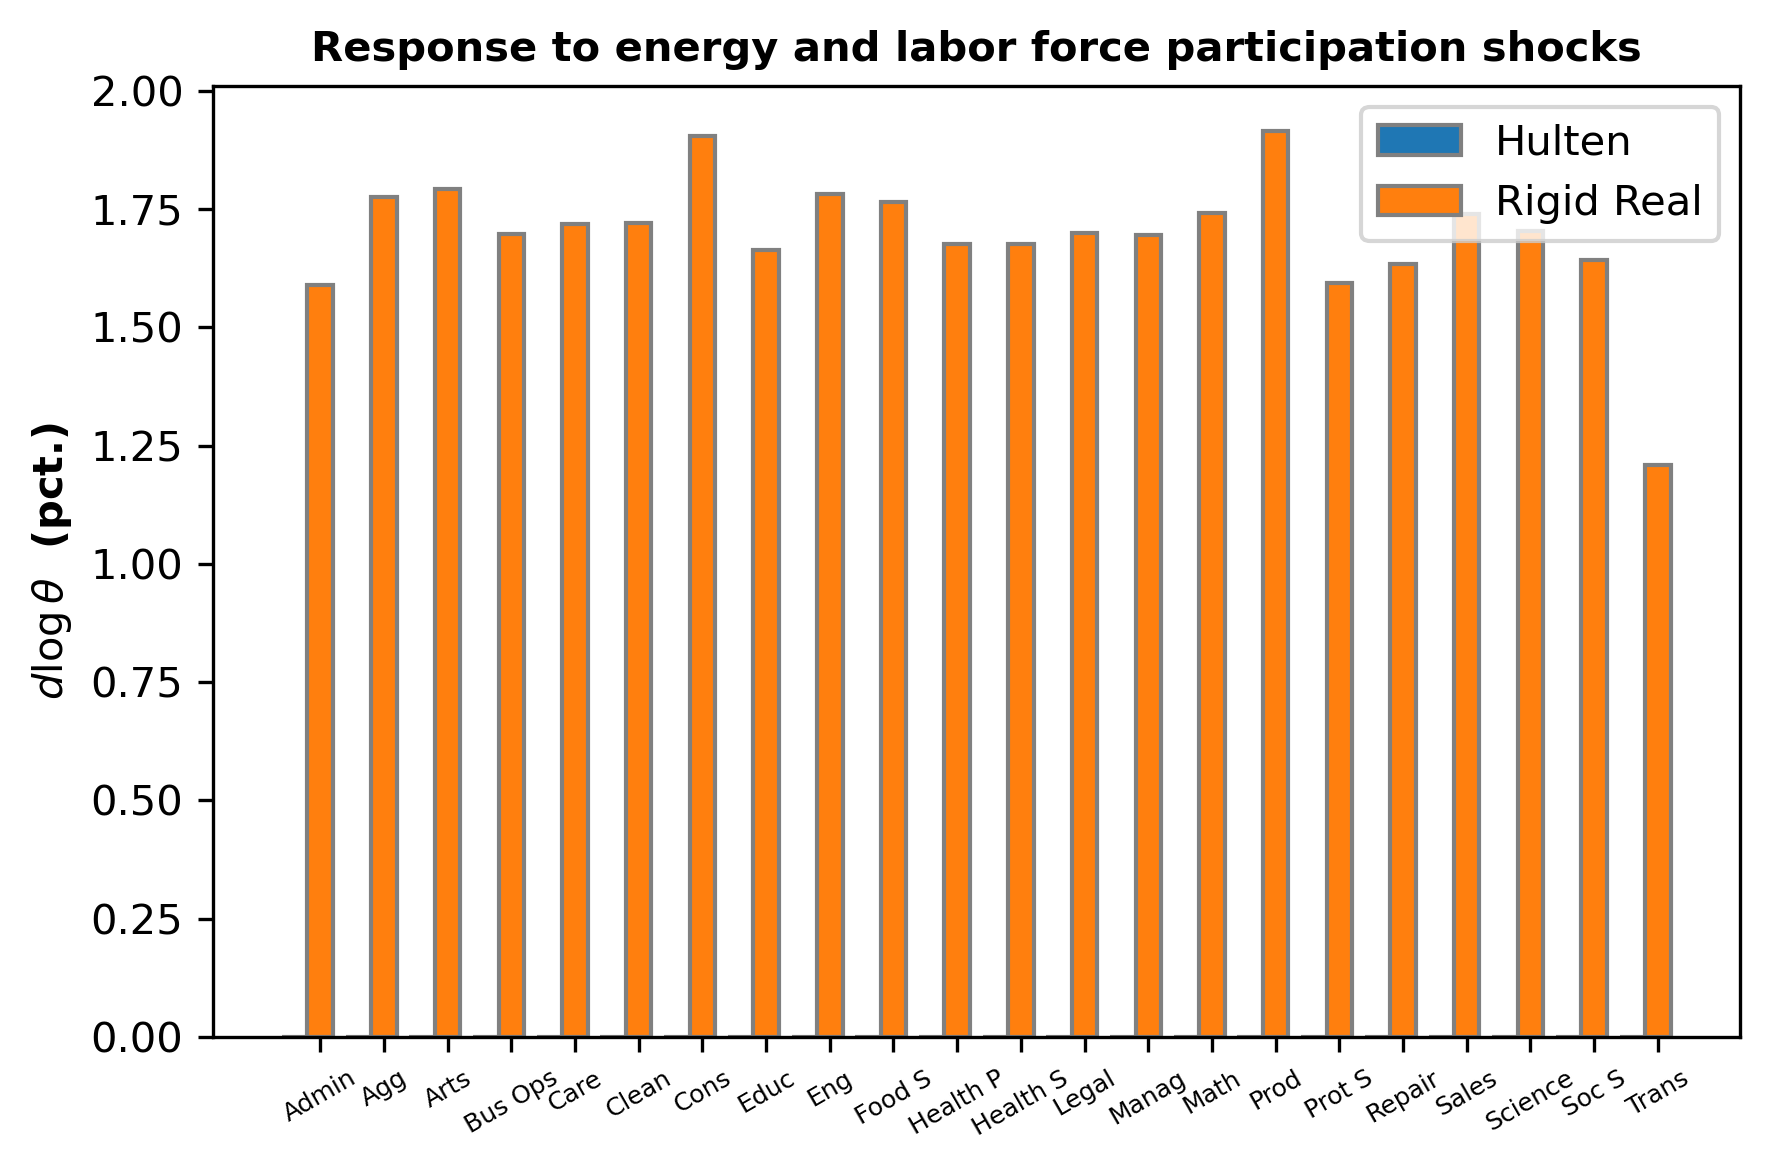

In [40]:
xlab = ''
ylab = '$d\log \\theta$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HKshockT.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)

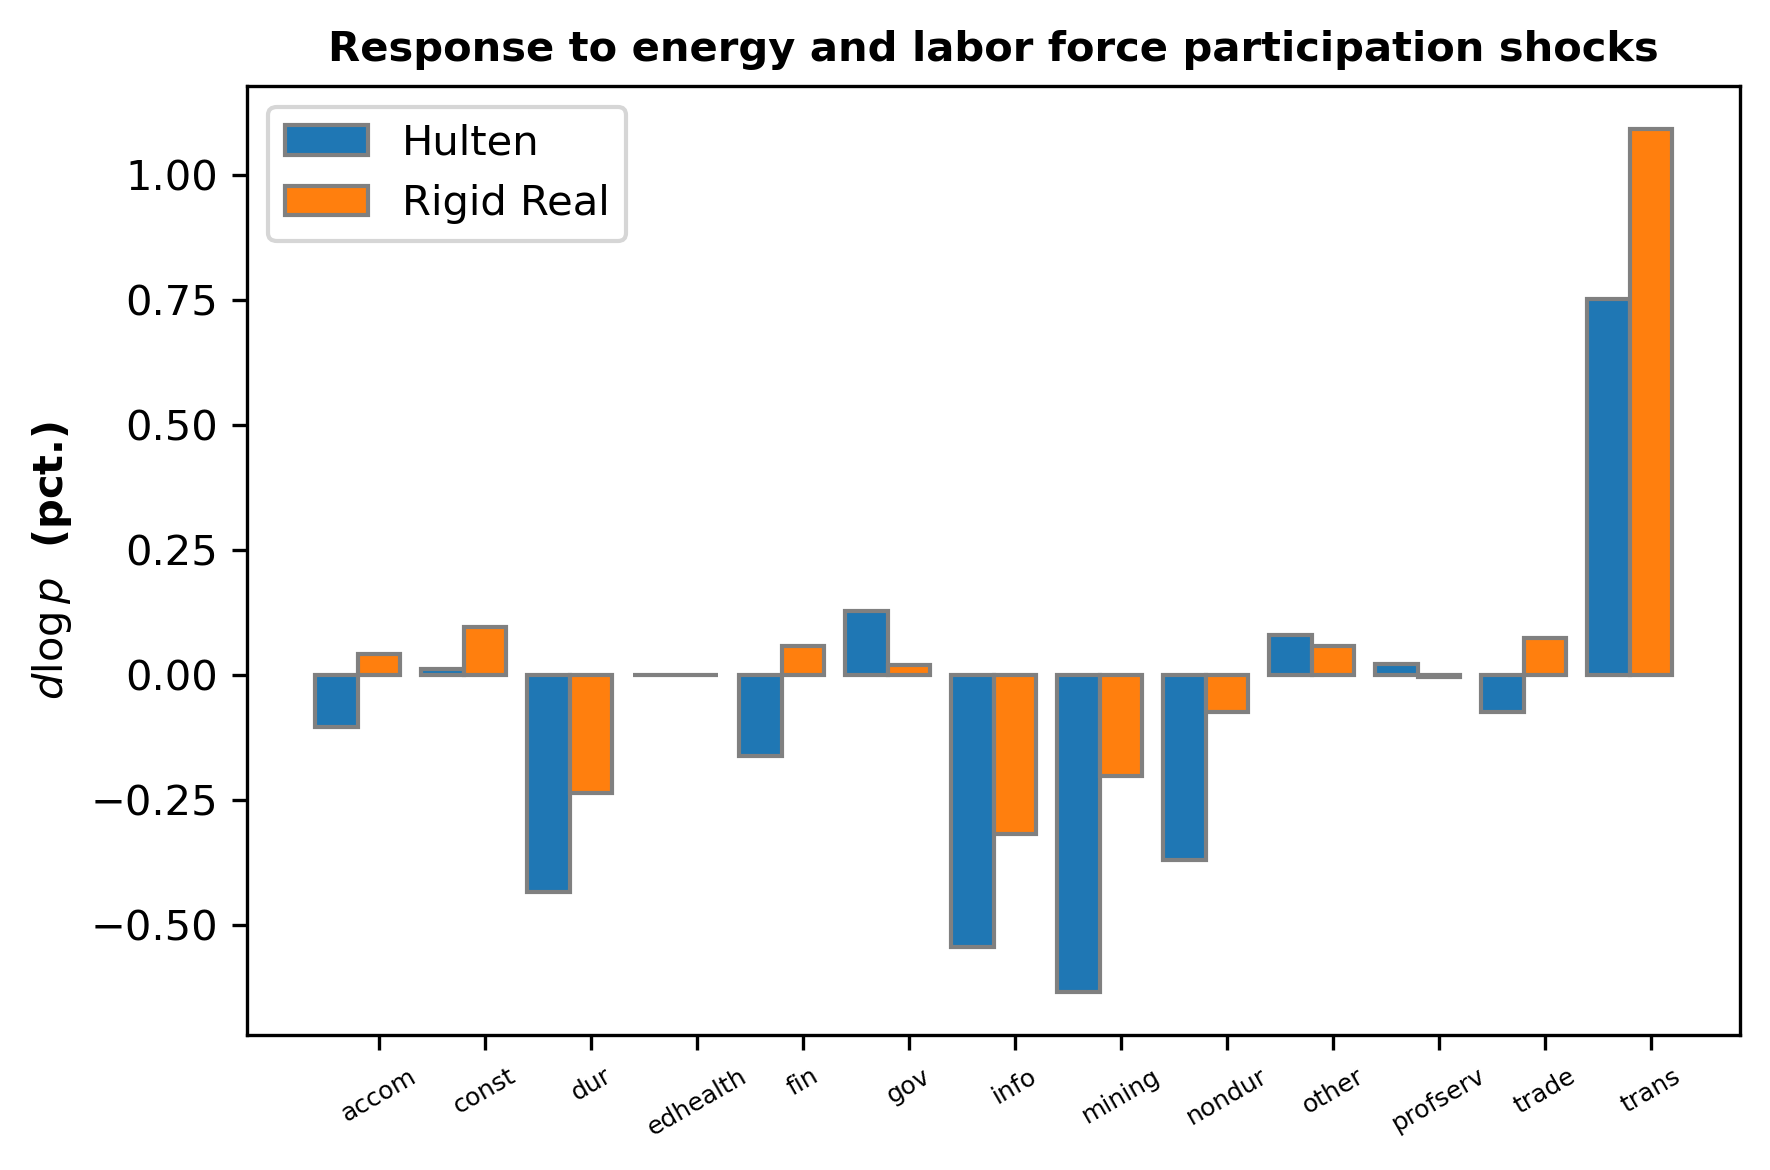

In [41]:
xlab = ''
ylab = '$d\log p$  (pct.)'
save_path = f'../output/figures/calib3/A{A_spec}/energy_HKshockP.png'
labels = PriceAssumption
bar_plot(100*p_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.40, dpi=300)